# Comparative study of Elo-MMR vs. The CodeChef Rating Sytem

In this notebook, we compare the Elo-MMR and CodeChef tating systems across the history of CodeChef contests. As detailed in our [paper](https://github.com/EbTech/Elo-MMR/tree/master/paper), Elo-MMR is a robust, statiscally principled rating system for massive multiplayer contests. We developed this system primarily with coding competitions in mind, and have done extensive comparisons with the Topcoder and CodeChef rating systems. The main benefits of Elo-MMR are:
- Speed and accuracy. Elo-MMR is at least an order of magnitude (typically more) faster than existing rating systems, and more accurate as well.
- Incentive-compatibility. Elo-MMR does not incentivize players to perform less than their best (unlike Topcoder and CodeChef, which can be attacked through so-called "volatility farming" attacks).
- Transparency. The entire codebase is open-source, and can be found [here](https://github.com/EbTech/Elo-MMR).
- Robustness. Elo-MMR does not severely penalize players for a single bad day.

At the present moment, Elo-MMR has been implemented in production at [dmoj.ca](dmoj.ca), a contest system used primarily by Canadian competitive programmers. Our goal with this notebook will be to verify the above benefits on the CodeChef contest data, and to inform a transition from the CodeChef rating system to Elo-MMR. 

In [1093]:
# First, generate the data by running on the command line:
# cd multi-skill
# RUST_LOG=debug cargo run --release --bin codechef_checkpoints
# RUST_LOG=debug cargo run --release --bin mmr_from_cc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
from tqdm.notebook import tqdm

First, we do some data cleaning / preprocessing. The code below will read the following:
- All CodeChef contests since its inception
- Monthly checkpoints of CodeChef ratings
- Monthly checkpoints of Elo-MMR ratings
- Various metadata (contest times, CodeChef numerical handles, etc.)

The monthly checkpoints were computed from our Rust codebase using the `codechef_checkpoints.rs` file. The entire CodeChef history of 667 contests (at the time of writing) took approximately 27 seconds to process using our `mmr-fast` algorithm.

In [1094]:
from collections import defaultdict, Counter
import json

# Read in mappings of ids to username
root_dir = '/home/work_space/elommr-data'
user_csv = pd.read_csv(f'{root_dir}/user_ids_usernames_mapping.csv')

# For some reason user 33713 is not known
user_map = defaultdict(lambda: 'unknown_user')
userid_map = defaultdict(lambda: -1)
for userid, username in zip(user_csv.userid, user_csv.username):
    user_map[userid] = username
    userid_map[username] = userid
    
# Read in Codechef ranklist + our ranking system
codechef_dir = f'{root_dir}/ratings'
elommr_dir = f'{root_dir}/elommr-checkpoints/codechef'

# Set of contest names that are checkpointed
checkpoint_contests = set([contest[:-4] for contest in os.listdir(codechef_dir) if contest[-4:] == '.csv'])

# Get contest ids corresponding to these contest names
raw_contests = f'{root_dir}/var/www/elo_mmr/current/cache/codechef'
name_to_id, id_to_name, name_to_time = {}, {}, {}
all_contests = [contest for contest in os.listdir(raw_contests) if contest[-5:] == '.json']
all_contests = sorted(all_contests, key=lambda x: int(x[:-5]))

# Get list of cheaters and active users. These will be the users we measure our rating system on
actives = pd.read_csv(f'{root_dir}/CodeChefActiveUsers.csv')
cheaters = pd.read_csv(f'{root_dir}/CodeChefCheatersList.csv')
filtered_users = set(actives.username) - set(cheaters.username)

# Create helper functions for filtering out users we care about
def filter_users(df):
    return df[df['username'].isin(filtered_users)]

In [1095]:
# Go through history of contests and get number of contests participated in by each user
# Also compute some mappings of contest names to contest ids
num_contests = defaultdict(int)
for contest in tqdm(all_contests):
    ranks = json.load(open(f'{raw_contests}/{contest}'))
    cid = int(contest[:-5])
    contest_name = ranks['name']
    
    name_to_id[ranks['name']] = cid
    id_to_name[cid] = contest_name
    name_to_time[contest_name] = ranks['time_seconds']
    
    for user in [user_map[int(r[0])] for r in ranks['standings']]:
        num_contests[user] += 1
        
    if contest_name in checkpoint_contests:
        # Save number of contests participated in by each user
        df = pd.DataFrame(data={'username': list(num_contests.keys()), 'num_contests': list(num_contests.values())})
        df.to_csv(f'{root_dir}/elommr-checkpoints/codechef/{contest_name}_numcontests.csv')

  0%|          | 0/689 [00:00<?, ?it/s]

## Measuring accuracy: rank deviation

In the code below, we measure a simple statistic for accuracy: the rank deviation. The rank deviation is the expected percentage your predicted rank (from the rating system) differs from your actual rank in the contest. Mathematically, the rank deviation of a player $i$ in a contest with $n$ participants is: 

$$\text{rank_deviation}_i = |\text{actual_rank}_i - \text{predicted_rank}_i| / (n-1).$$

When player $i$ is tied with other players, we measure the difference of the actual rank to the nearest endpoint of the interval of players $i$ is tied with (or $0$ if the predicted rank lies within the interval).

In [1143]:
import math
# For each contest, measure statistics between ranklists
def rank_dev(r, lo, hi):
    return min(abs(r - lo), abs(r - hi), 0 if lo <= r <= hi else math.inf)

def produce_rankings(pred):
    # Sort rankings by reverse rating
    return dict([(pred[0], i) for i, pred in enumerate(sorted(pred, key=lambda x: -x[1]))])

# Min number of contests a user needs to do before being counted in our metrics
min_experience_level = 3
default_rating = 1500

unknown_users = set()
rankdev_mmr, rankdev_cc = 0, 0
pairinv_mmr, pairinv_cc = 0, 0
num_obs = 0

checkpoint_contests = sorted(list(checkpoint_contests), key=lambda x: name_to_id[x])
for contest in tqdm(checkpoint_contests):
    # Get the contest data corresponding to contest following this checkpoint
    contest_id = name_to_id[contest] + 1
    ranks = json.load(open(f'{raw_contests}/{contest_id}.json'))
    
    if ranks['time_seconds'] >= name_to_time['START25B']:
        default_rating = 1000
        
    codechef_rank = pd.read_csv(f'{codechef_dir}/{contest}.csv')
    codechef_rank.sort_values(['ratings'], ascending=False, inplace=True)
    rate_name_cc = defaultdict(lambda: default_rating)
    rate_name_cc.update(dict(zip(codechef_rank.username, codechef_rank.ratings)))
    
    mmr_rank = pd.read_csv(f'{elommr_dir}/{contest}.csv')
    # Translate handle ids to actual usernames
    mmr_rank.handle = mmr_rank.handle.apply(lambda x: user_map[x])
    mmr_rank['username'] = mmr_rank.handle
    rate_name_mmr = defaultdict(lambda: default_rating)
    rate_name_mmr.update(dict(zip(mmr_rank.handle, mmr_rank.display_rating)))
    
    # For each user in the contest, get their predicted rank from both ranklists
    mmr_pred, codechef_pred = [], []
    for result in ranks['standings']:
        user = user_map[int(result[0])]
        if user != 'unknown_user':
            mmr_pred.append((user, rate_name_mmr[user]))
            codechef_pred.append((user, rate_name_cc[user]))
        else:
            unknown_users.add(int(result[0]))
    
    # Sort the predictions to get the actual rankings
    mmr_final, codechef_final = produce_rankings(mmr_pred), produce_rankings(codechef_pred)
    
    # Get the number of contests each user has participated in thus far
    num_contest_csv = pd.read_csv(f'{elommr_dir}/{contest}_numcontests.csv')
    num_contests = defaultdict(int)
    num_contests.update(dict(zip(num_contest_csv.username, num_contest_csv.num_contests)))
    
    # Compute various statistics over users that have participated in at least 3 contests
    num_participants = len(ranks['standings'])
    for result in ranks['standings']:
        user = user_map[int(result[0])]
        if num_contests[user] < min_experience_level:
            # Note: num_contests includes the current contest, so an entry of 3 indicates 2 contests have been done
            # before the current one
            continue
        
        r_mmr = mmr_final[user]
        r_cc = codechef_final[user]
        
        rankdev_mmr += rank_dev(r_mmr, *result[1:]) / (num_participants - 1)
        rankdev_cc += rank_dev(r_cc, *result[1:]) / (num_participants - 1)
        
        num_obs += 1
    
print('Ranking deviation percentage (mmr vs. cc):', rankdev_mmr / num_obs, rankdev_cc / num_obs)

  0%|          | 0/158 [00:00<?, ?it/s]

Ranking deviation percentage (mmr vs. cc): 0.1813299979858752 0.1937954106820019


As expected, the Elo-MMR algorithm is slightly more accurate with a ~6.5% lower ranking deviation metric.

# Distribution and support of ratings

Next, we'll plot the distribution of the ratings. The code below does this. In addition, it plots the ratings of the top k participants according to the rating system.

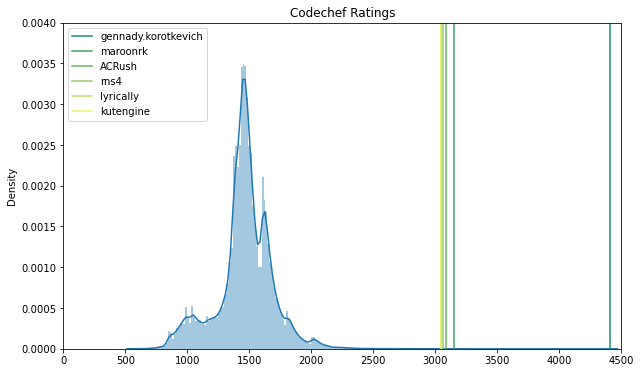

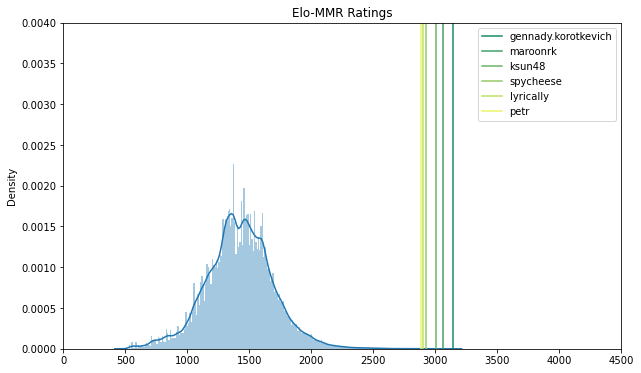

In [1146]:
import seaborn as sns
from matplotlib import rcParams, cm
import matplotlib.pyplot as plt

# Add same columns to mmr ratings
mmr_rank['username'] = mmr_rank.handle
mmr_rank['ratings'] = mmr_rank.cur_mu

rcParams['figure.figsize'] = (10, 6)

xlo, xhi = 0, 4500
ylo, yhi = 0, 0.004
def plot_top_k(rankings, k=6):
    cmap = cm.get_cmap('summer')
    for i in range(k):
        col = cmap((i+1/2)/k)
        plt.axvline(rankings.ratings.iloc[i], label=rankings.username.iloc[i], color=col)
    plt.legend()
        
def plot_distribution(rankings, title, ax=None, k=6):
    if not ax:
        plt.figure()
    # Filter out cheaters and non-active users
    filtered = filter_users(rankings)
    data = pd.DataFrame(data={'data': filtered.ratings})
    ax = sns.distplot(data, bins=250)
    plot_top_k(rankings, k)
    ax.set_xlim([xlo, xhi]);
    ax.set_ylim([ylo, yhi]);
    ax.set_title(title);

plot_distribution(codechef_rank, 'Codechef Ratings')
plot_distribution(mmr_rank, 'Elo-MMR Ratings')

We see that Elo-MMR exhibits a much smaller range of support, whereas ratings for CodeChef are significantly inflated (up to over 4400). In particular, the rating gap between `gennady.korotkevich` and second place `maroonrk` reaches almost 1300 for CodeChef, but is only 80 points in Elo-MMR. CodeChef also tends to overuse the middle range of the distribution (around 1500), whereas Elo-MMR ratings are spread much more smoothly.

# Top-50 Ranking Differences

Let's first take a look at the raw ranklists of the top 50. On the left we have CodeChef, and on the right we have Elo-MMR. We see many common names (in green) between the two lists. In fact, almost 75% of the top-50 list overlaps. 

In [1150]:
import numpy as np

# Filter out non-active and cheating users
codechef_rank = pd.DataFrame(filter_users(codechef_rank))
mmr_rank = pd.DataFrame(filter_users(mmr_rank))

cc_top50 = codechef_rank.iloc[:50]
mmr_top50 = mmr_rank[['username', 'ratings']].iloc[:50]

overlap = set(cc_top50.username) & set(mmr_top50.username)

print('Overlapping top-50 players:')
print(overlap)
print('Size of overlap:', len(overlap), '\n')

print('Unique Elo-MMR players:', set(mmr_top50.username) - overlap)
print('Unique CodeChef players:', set(cc_top50.username) - overlap)

# We need to rename some columns now so that when we merge them, column names are unique
cc_top50.rename(columns={'username': 'username (cc)', 'ratings': 'ratings (cc)'}, inplace=True)
mmr_top50.rename(columns={'username': 'username (mmr)', 'ratings': 'ratings (mmr)'}, inplace=True)

def custom_style(df):
    c = df[['username (cc)', 'username (mmr)']].isin(overlap)
    c0, c1 = c.to_numpy()[:,0:1], c.to_numpy()[:,1:2]
    mask = np.concatenate([np.repeat(c0, 2, axis=1), np.repeat(c1, 2, axis=1)], axis=1)
    a = np.where(mask, 'background-color: lightgreen', 'background-color: lightyellow')
    return pd.DataFrame(a, columns=df.columns, index=df.index)

combined = pd.concat([d.reset_index(drop=True) for d in [cc_top50, mmr_top50]], axis=1)
s = combined.reset_index(drop=True).style.apply(custom_style, axis=None)
display(s)

Overlapping top-50 players:
{'tute7627', 'peehs_moorhsum', 'risujiroh', 'progmatic', 'vercingetorix', 'uwi', 'natsugiri', 'ssrs', 'grumpy_gordon', 'akatorihasi180', 'lyrically', 'isaf27', 'spycheese', 'alex_2oo8', 'b524', 'bench0310', 'kotatsugame', 'heno239', 'ecnerwala', 'oilhun', 'ksun48', 'argos', 'neal', 'maksim1744', 'kal013', 'petr', 'EgorK', 'html_sanek', 'endagorion', 'maroonrk', 'tmwilliamlin', 'sansen', 'bigbag', 'geothermal', 'gennady.korotkevich', 'noimi', 'zemen'}
Size of overlap: 37 

Unique Elo-MMR players: {'tabr', 'tiago_marques', 'scheffeli', 'wasa855', 'celesta', 'hitonanode', 'rns_cus', 'icecuber', 'rubikun', 'potato167', 'xaphoenix', 'krismaz', 'jeroenodb'}
Unique CodeChef players: {'nyaan', 'moransky', 'satashun', 'jijiang', 'Oleg', 'stonefeang', 'kut_hgs1997', 'fjzzq2002', 'tlatoani', 'jtnydv25', 'dreamoon4', 'bthero', 'anton_trygub'}


,username (cc),ratings (cc),username (mmr),ratings (mmr)
0,gennady.korotkevich,4410,gennady.korotkevich,3141
1,maroonrk,3148,maroonrk,3064
2,lyrically,3046,ksun48,3008
3,ksun48,3033,spycheese,2921
4,petr,3020,lyrically,2899
5,peehs_moorhsum,2971,petr,2885
6,progmatic,2935,peehs_moorhsum,2857
7,b524,2910,heno239,2860
8,neal,2898,noimi,2841
9,spycheese,2895,neal,2821


# Relationship between CodeChef and Elo-MMR ratings

Next, let's look at the relationship between CodeChef and Elo-MMR ratings for the players. We'll sample 20000 random players from the player base and plot their ratings in the two systems.

Text(0, 0.5, 'Elo-MMR minus CodeChef rating')

<Figure size 720x432 with 0 Axes>

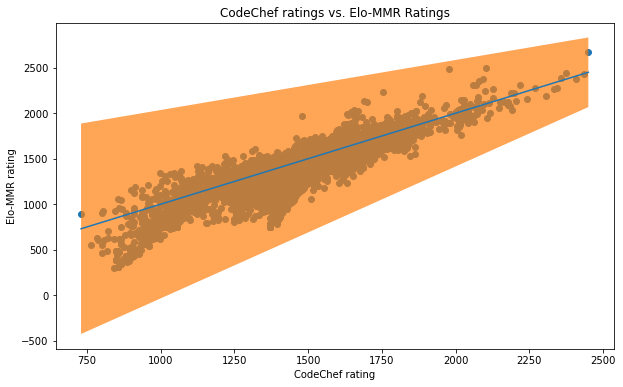

<Figure size 720x432 with 0 Axes>

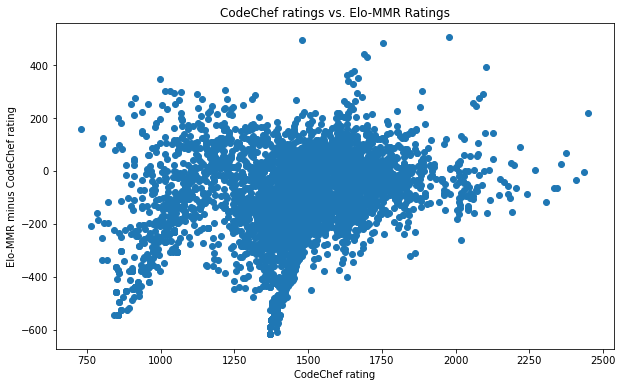

In [1152]:
import matplotlib
from scipy.odr import *
from scipy.stats import linregress

num_samples = 5000
samples = codechef_rank.sample(num_samples, axis=0)
cc_random = codechef_rank[codechef_rank['username'].isin(samples.username)]
mmr_random = mmr_rank[mmr_rank['handle'].isin(samples.username)][['cur_mu', 'handle']]
mmr_random.rename(inplace=True, columns={'cur_mu': 'ratings', 'handle': 'username'})

union = set(cc_random.username) | set(mmr_random.username)

# This cell requires running all previous cells in the notebook to gather precomputed values
x_cc, y_mmr, names = [], [], []
for username in union:
    x_cc.append(rate_name_cc[username])
    y_mmr.append(rate_name_mmr[username])
    names.append(username)
    
plt.figure()
fig, ax = plt.subplots() 
plt.scatter(x_cc, y_mmr)
plt.title('CodeChef ratings vs. Elo-MMR Ratings')
plt.xlabel('CodeChef rating')
plt.ylabel('Elo-MMR rating')

X = np.array(sorted(x_cc))
Yl = 0.55 * (X - 3300) + 3300
Yh = 1.45 * (X - 3300) + 3300
plt.fill_between(X, Yl, Yh, alpha=0.7)
plt.plot(X, X)


plt.figure()
fig, ax = plt.subplots() 
# y_mmr_squeeze = 1500 + (np.array(y_mmr) - 1500) * 330 / 300
plt.scatter(x_cc, np.array(y_mmr) - np.array(x_cc))
#plt.scatter(y_mmr_squeeze,  np.array(x_cc) - y_mmr_squeeze)
plt.title('CodeChef ratings vs. Elo-MMR Ratings')
plt.xlabel('CodeChef rating')
plt.ylabel('Elo-MMR minus CodeChef rating')

The trend is not perfectly linear, as we saw earlier that the distributions of Elo-MMR and CodeChef ratings are vastly different in shape. It seems that the difference between the two is larger towards the lower range of CodeChef ratings (below 2200). The two lines going through x = 1000 and x = 1500 are exactly the set of users who have participated in one round, as we can see by the plot when we filter them out:

Text(0, 0.5, 'Elo-MMR minus CodeChef rating')

<Figure size 720x432 with 0 Axes>

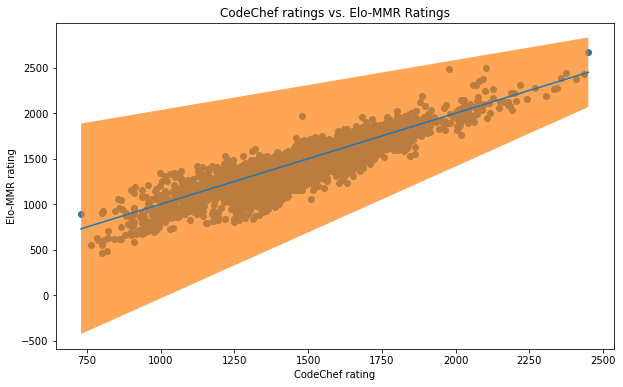

<Figure size 720x432 with 0 Axes>

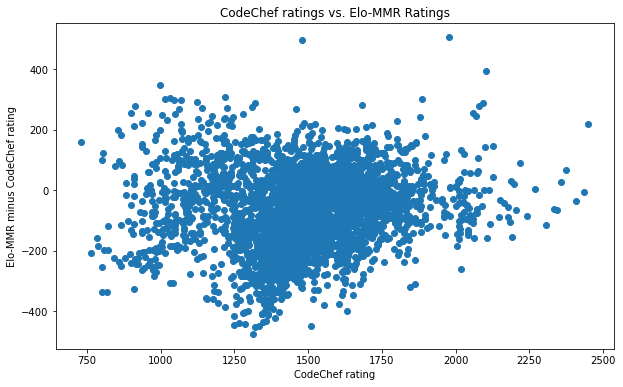

In [1153]:
# This cell requires running all previous cells in the notebook to gather precomputed values
x_cc, y_mmr, names = [], [], []
for username in union:
    if num_contests[username] > 1:
        x_cc.append(rate_name_cc[username])
        y_mmr.append(rate_name_mmr[username])
        names.append(username)
    
plt.figure()
fig, ax = plt.subplots() 
plt.scatter(x_cc, y_mmr)
plt.title('CodeChef ratings vs. Elo-MMR Ratings')
plt.xlabel('CodeChef rating')
plt.ylabel('Elo-MMR rating')

X = np.array(sorted(x_cc))
Yl = 0.55 * (X - 3300) + 3300
Yh = 1.45 * (X - 3300) + 3300
plt.fill_between(X, Yl, Yh, alpha=0.7)
plt.plot(X, X)


plt.figure()
fig, ax = plt.subplots() 
# y_mmr_squeeze = 1500 + (np.array(y_mmr) - 1500) * 330 / 300
plt.scatter(x_cc, np.array(y_mmr) - np.array(x_cc))
#plt.scatter(y_mmr_squeeze,  np.array(x_cc) - y_mmr_squeeze)
plt.title('CodeChef ratings vs. Elo-MMR Ratings')
plt.xlabel('CodeChef rating')
plt.ylabel('Elo-MMR minus CodeChef rating')

# Transitioning CodeChef to Elo-MMR

The transition from CodeChef's current rating system to Elo-MMR is tricky, as the two rating systems produce different distributions and different scales. The different scales can easily be corrected, as one can scale Elo-MMR ratings to cover approximately the same range of values as CodeChef. The shape of the two distributions present issues however. Due to the high density of ratings near 1500 for CodeChef's ratings, it's likely that Elo-MMR will greatly increase the average rating of participants just above 1500, and greatly decrease the average rating of participants just below 1500 (and of tourist). This would lead to many participants being unhappy with the new rating system, as their ratings would rapidly decrease.

One possible solution is to shift the ratings of Elo-MMR so that at least 80% of users expect a rating increase after the rating system change. Another is to shift the ratings so that on average, a user experiences 0 change in their ratings. 

Below we compute these two rating shifts, beginning with the 80% solution.

In [1155]:
# Refresh these ratings with ratings filtered by active non-cheaters
rate_name_cc = defaultdict(lambda: default_rating)
rate_name_cc.update(dict(zip(codechef_rank.username, codechef_rank.ratings)))
rate_name_mmr = defaultdict(lambda: default_rating)
rate_name_mmr.update(dict(zip(mmr_rank.handle, mmr_rank.cur_mu)))
    
def percent_happy(s, explvl=0):
    nsucc, ntot = 0, 0
    for name in rate_name_mmr:
        if num_contests[name] < explvl:
            continue
        if rate_name_cc[name] <= rate_name_mmr[name] + s:
            nsucc += 1
        ntot += 1
    return nsucc / ntot

def compute_shift(prop, explvl=0):
    l, r = -1200, 1200
    while abs(r - l) > 1e-1:
        m = (l + r) / 2
        if percent_happy(m, explvl) >= prop:
            r = m
        else:
            l = m
    return (l + r) / 2

print('Rating shift (80%) is', compute_shift(0.80))

Rating shift (80%) is 146.00830078125


Let's see how the rating shift evolves as we vary the proportion required.

Text(0, 0.5, 'Percentage of users experiencing rating increase')

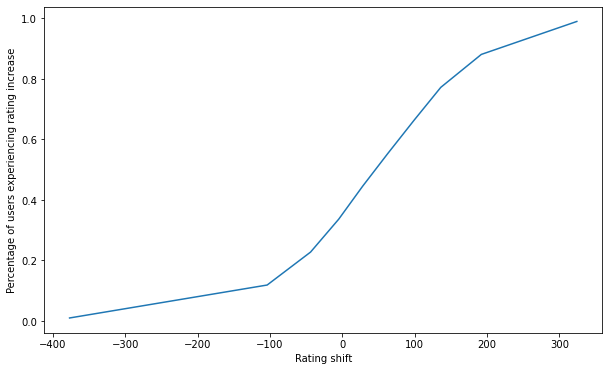

In [1156]:
X = np.linspace(0.01, 0.99, 10)
Y = [compute_shift(x) for x in X]
plt.plot(Y, X) 
plt.xlabel('Rating shift')
plt.ylabel('Percentage of users experiencing rating increase')

Let's break things down by experience next. We'll examine what shift is needed for various levels of contest experience.

Text(0, 0.5, 'Rating shift required to get 80% increase')

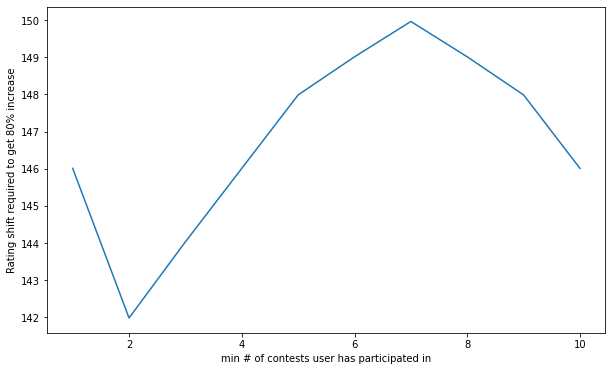

In [1157]:
Y = [compute_shift(0.80, exp) for exp in range(1, 11)]
X = list(range(1, 11))
plt.plot(X, Y)
plt.xlabel('min # of contests user has participated in')
plt.ylabel('Rating shift required to get 80% increase')

As we can see, higher values of rating shift are mostly required for less experienced users. We can also see this in the "CodeChef Ratings vs. Elo-MMR Ratings" plot that we generated earlier, as the spread between the ratings was largest for lower rated players (lower rated players are correlated with fewer contests). This means that higher rated users will essentially experience the same ratings with the new system.

Let's compute now the rating shift required so that on average, a user's rating changes by 0.

Text(0, 0.5, 'Average rating change')

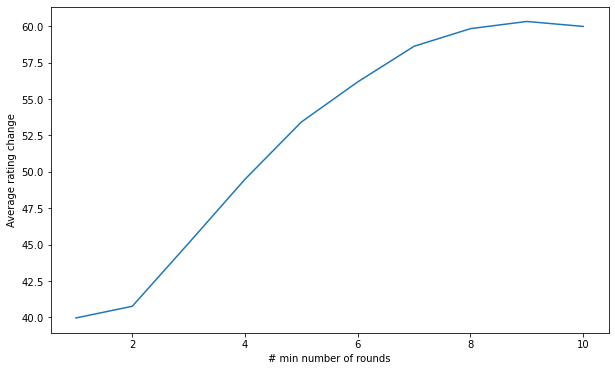

In [1163]:
def avg_rating_change(explvl=0):
    sum_change = 0
    ntot = 0
    for name in rate_name_mmr:
        if num_contests[name] < explvl:
            continue
        sum_change += rate_name_cc[name] - rate_name_mmr[name]
        ntot += 1
    return sum_change / ntot

X = list(range(1, 11))
Y = [avg_rating_change(lvl) for lvl in X]
plt.plot(X, Y) 
plt.xlabel('# min number of rounds')
plt.ylabel('Average rating change')

On average, we should inflate MMR ratings by about 40 points for most people to experience a net-zero rating change *in the long run* (i.e. after the system has converged). This would give a boost in rating of up to 40 points over their current value to everyone who has participated in more than 1 round.

Luckily, the "display rating" mechanism (where we show a user's rating as their true rating minus 3 std. dev.), can be tuned to automatically account for this to slowly reflect a 40 point rating boost over time.

# Users expected to drastically gain or lose rating

Here we compute a list of all users whose ratings will drastically change (>500 points) with the new system, assuming that the MMR system has been shifted by 120 rating points as described in the previous section.

We'll filter out non-active users and users who have only participated in one contest.

,username,rating_change
0,gennady.korotkevich,-1229
1,nok0,858
2,arielgg,848
3,hibye1217,836
4,scimoon,820
...,...,...
74,notwatermango,514
75,jell,504
76,azus66,503
77,wargang2,502


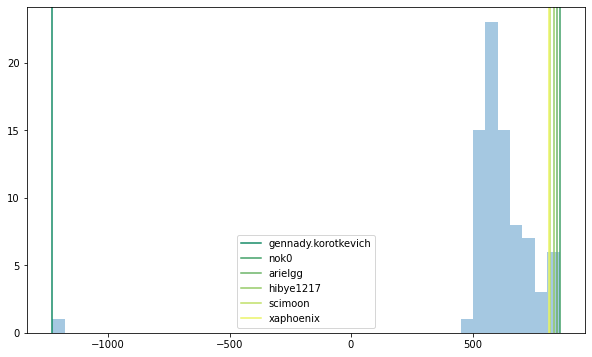

In [1168]:
shift = 40
limit = 500
contest = checkpoint_contests[-1]
codechef_rank = pd.read_csv(f'{codechef_dir}/{contest}.csv')
codechef_rank.sort_values(['ratings'], ascending=False, inplace=True)
rate_name_cc = defaultdict(lambda: default_rating)
rate_name_cc.update(dict(zip(codechef_rank.username, codechef_rank.ratings)))

mmr_rank = pd.read_csv(f'{elommr_dir}/{contest}.csv')
# Translate handle ids to actual usernames
mmr_rank.handle = mmr_rank.handle.apply(lambda x: user_map[x])
mmr_rank['username'] = mmr_rank.handle
rate_name_mmr = defaultdict(lambda: default_rating)
rate_name_mmr.update(dict(zip(mmr_rank.handle, mmr_rank.cur_mu)))

extreme_cases = []
for user in num_contests:
    if user not in filtered_users or num_contests[user] <= 1:
        continue
    if abs(rate_name_mmr[user] + shift - rate_name_cc[user]) >= limit:
        extreme_cases.append((user, rate_name_mmr[user] + shift - rate_name_cc[user]))
        
# Let's print out the distribution of extreme cases
extreme_df = pd.DataFrame({'username': [data[0] for data in extreme_cases], 'rating_change': [data[1] for data in extreme_cases]})
extreme_df = extreme_df.sort_values(['rating_change'], ascending=False, key=lambda x: abs(x)).reset_index(drop=True)
display(extreme_df)

# Temporarily create 'ratings' column to use functions we've implemented before
extreme_df['ratings'] = extreme_df.rating_change
plt.figure()
data = pd.DataFrame(data={'data': extreme_df.ratings})
ax = sns.distplot(data, norm_hist=False, kde=False)
plot_top_k(extreme_df)

del extreme_df['ratings']
extreme_df.to_csv(f'{root_dir}/extreme_cases.csv', index=False)

As we can see, there are 79 users that are at or above the 500 rating change limit. Many of these users are due to the Div 3-4 issue we discussed in our meetings (where our system puts the user into a higher division, but our simulation allowed them to gain rating points from future Div. 3-4 contests they participated in).

# Initializing Elo-MMR with CodeChef ratings

In this section, we initialize Elo-MMR with CodeChef ratings from a year ago and answer questions such as:
- How fast will the rating distribution change?
- What will the rating distribution converge to?
- How will the top-ranked players change?

In [1186]:
import time
import datetime

# Determine closest contest a year ago from today
ts = time.mktime(datetime.datetime.strptime("25/04/2022", "%d/%m/%Y").timetuple()) - 31557600

# Figure out which CodeChef contest this is
sid = 0
for i, contest in enumerate(checkpoint_contests):
    if name_to_time[contest] > ts:
        sid = i
        print('Cutoff contest:', contest)
        break
        
contest = checkpoint_contests[sid]
codechef_rank = pd.read_csv(f'{codechef_dir}/{contest}.csv')

num_contest_csv = pd.read_csv(f'{elommr_dir}/{contest}_numcontests.csv')

merged = pd.merge(codechef_rank, num_contest_csv)
merged = merged.drop([merged.columns[2]], axis=1)
merged['username'] = merged['username'].apply(lambda x: userid_map[x])
# merged['cur_sigma'] = 350.
merged = merged.rename(columns={'username': 'handle', 'ratings': 'cur_mu'})
display(merged)

contest_id = name_to_id[contest]
# Save this as the initial condition
merged.to_csv(f'/home/work_space/elommr-data/cc_init_condition-{contest}-{contest_id}.csv', index=False)

Cutoff contest: MAY21B


,handle,cur_mu,num_contests
0,16,1468,1
1,17,1171,22
2,21,1552,1
3,22,1507,9
4,42,1346,3
...,...,...,...
328106,2416550,1386,1
328107,2416556,1386,1
328108,2416563,1413,1
328109,2416568,1411,1


Now that we've created the initial conditions for Elo-MMR to start from, we can run our system to see how the rating changes when we transition. We've run this computation offline. The code below reads in and analyzes the results.

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0, 0.5, 'Average rating gap')

<Figure size 720x432 with 0 Axes>

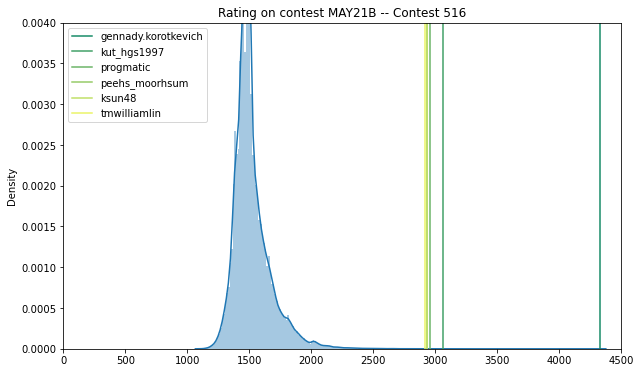

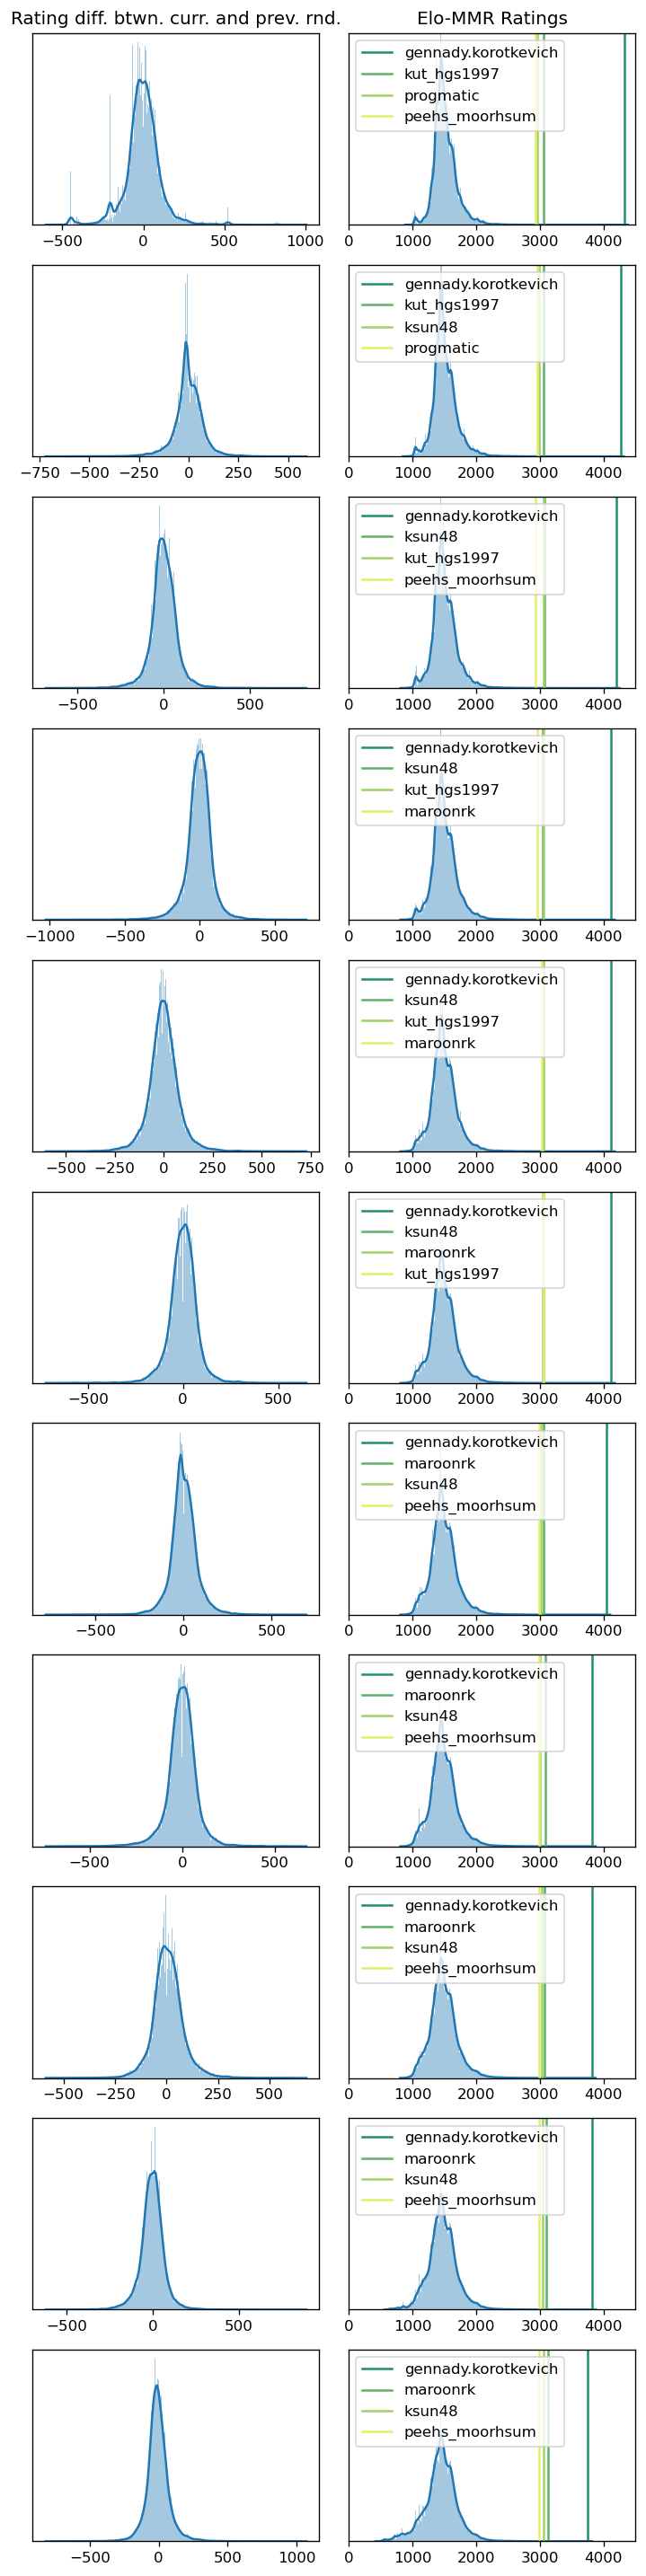

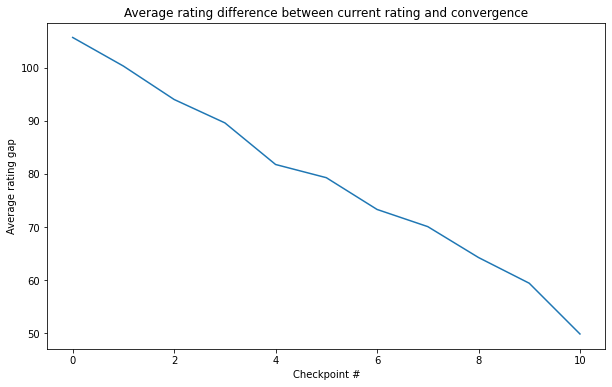

In [1187]:
current_rating = pd.DataFrame(codechef_rank)
current_rating = filter_users(current_rating)
current_rating.sort_values(['ratings'], ascending=False, inplace=True)

rate_cur = defaultdict(lambda: default_rating)
rate_cur.update(dict(zip(current_rating.username, current_rating.ratings)))

plt.figure()
plot_distribution(current_rating, f'Rating on contest {contest} -- Contest {contest_id}')

# Min number of contests a user needs to do before being counted in our metrics
min_experience_level = 3
default_rating = 1500

# Makes the mean rating shift small for most users
rating_shift = 0 

fig = plt.figure(figsize=(6, 24), dpi=120)
cnt = 1
cc_to_mmr_dir = f'{root_dir}/elommr-checkpoints/start-from-516'
gap_per_checkpoint = []
for contest in tqdm(checkpoint_contests[sid+1:]):
    if ranks['time_seconds'] >= name_to_time['START25B']:
        default_rating = 1000
        
    next_rating = pd.read_csv(f'{cc_to_mmr_dir}/{contest}.csv')
    # Translate handle ids to actual usernames
    next_rating['username'] = next_rating.handle.apply(lambda x: user_map[x])
    next_rating['ratings'] = next_rating.cur_mu + rating_shift
    next_rating = filter_users(next_rating)
    rate_next = defaultdict(lambda: default_rating)
    rate_next.update(dict(zip(next_rating.username, next_rating.ratings)))
    
    rating_changes = [
        rate_next[name] - rate_cur[name]
        for name in rate_cur if rate_next[name] - rate_cur[name] != 0
    ]
    max_rating_change, min_rating_change = np.max(rating_changes), np.min(rating_changes)
    med_rating_change, mean_rating_change = np.median(rating_changes), np.mean(rating_changes)
    # print(contest, min_rating_change, max_rating_change, med_rating_change, mean_rating_change)
    
    # Compute average rating gap between stationary distribution and current rating distribution
    ntot, gap = 0, 0
    for user in filtered_users:
        if user in rate_next and user in rate_name_mmr:
            gap += abs(rate_next[user] - rate_name_mmr[user])
            ntot += 1
    gap_per_checkpoint.append(gap / ntot)
        
    current_rating, rate_cur = next_rating, rate_next        
    
    plt.subplot(11, 2, cnt)
    data = pd.DataFrame(data={'data': rating_changes})
    ax = sns.distplot(data, bins=350)
    ax.get_yaxis().set_visible(False)
    if cnt == 1:
        ax.set_title("Rating diff. btwn. curr. and prev. rnd.")
    cnt += 1
    
    ax = plt.subplot(11, 2, cnt)
    if cnt == 2:
        title = 'Elo-MMR Ratings'
    else:
        title = ''
    plot_distribution(next_rating, title, ax, 4)
    ax.get_yaxis().set_visible(False)
    cnt += 1
    
fig.tight_layout()
plt.figure()
plt.plot(list(range(11)), gap_per_checkpoint)
plt.title('Average rating difference between current rating and convergence')
plt.xlabel('Checkpoint #')
plt.ylabel('Average rating gap')

# Switching vs Interpolating

**Switching** means that we take the current CodeChef ratings, convert them into a form that Elo-MMR can use (usually this means giving each player a sigma), and use these as an initial state from which to compute all future updates with Elo-MMR.

**Interpolating** means we run Elo-MMR from the beginning of CodeChef history, and use only Elo-MMR in backend calculations. However, CodeChef will continue to display old ratings, with updates that gradually attract it toward the backend Elo-MMR ratings:
$$\text{elo_mmr}_{n+1} =  \text{MMR_UPDATE}(\text{elo_mmr}_n)$$
$$\text{cc_rating}_{n+1} = \text{elo_mmr}_{n+1} + 0.75 * (\text{cc_rating}_n - \text{elo_mmr}_n)$$

To converge to, say, one-tenth of the starting error, a player must compete $\log(0.1) / \log(0.75) \approx 8$ times.

Both options are possible. We prefer interpolation because it instantly converges the backend ratings, upon which all calculations are based, to Elo-MMR ratings based on CodeChef's long and healthy history. This means visibly faster convergence too: as soon as a player's w is small, their display rating will be as good as if they had been using Elo-MMR all along. On the other hand, the advantage of switching is that display ratings will be closer to what the backend uses, and updates will be purely based on the latest contest rather than due to reweighting; both of these effects make rating updates more predictable to users (albeit at the cost of less predictable long-term and population-wide trends).

**Our suggested parameters for Elo-MMR**: mmr (slow version) with mu=1600, sigma=325, sigma_limit=75, weight=0.2. If we eventually want live rating predictions, split_ties=true might be preferable. Having a mu of 1600 ensures that most users will either gain points or remain stable as a result of the change. Newcomers are effectively rated 1600 - 3*(325-75) = 850.